# Use of a Neural-Network for Constitutive Law

To allow inline pictures, run the following block

In [51]:
%matplotlib inline
#%matplotlib notebook

Import all the useful libraries before first run
We need here the classic ones such as:
- math
- numpy
- pandas
- matplotlib

And for the Neural Network, we also need to import parts of the keras module of TensorFlow

In [52]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the test database

Read the Test database

In [53]:
dataPath = '.'

In [54]:
read = np.load(dataPath + '/DatatestWithDerivatives.npz')
testData = read['testData']
nrows = testData.shape[0]

In [55]:
eps_test = testData[:,0].reshape(nrows,1)
epsp_test = testData[:,1].reshape(nrows,1)
T_test = testData[:,2].reshape(nrows,1)
sig_test = testData[:,3].reshape(nrows,1)
#eps_test, epsp_test, T_test, sig_test

 ## Load the NN parameters

In [56]:
ANN_name = '3-9-1-sigmoid'
NN = np.load(dataPath + '/' + ANN_name + '.npz')
for key in NN:
    print (key)

logBase
minEntries
maxEntries
w1
b1
w2
b2


In [57]:
w1 = NN['w1']
w2 = NN['w2']
b1 = NN['b1']
b2 = NN['b2']
minEntries = NN['minEntries']
maxEntries = NN['maxEntries']
rangeEntries = maxEntries - minEntries
logBase = NN['logBase']
w1, b1, w2, b2, minEntries, maxEntries, rangeEntries, logBase

(array([[ 2.95951996e+01, -1.19563125e-01,  4.77388501e-01],
        [-6.73592806e+00,  1.19011864e-01, -3.85654628e-01],
        [ 8.61201167e-01, -4.07798529e-01, -2.34910473e-01],
        [-3.88005679e-03, -2.56618112e-01,  8.56014609e-01],
        [-1.27289498e+00, -4.76547889e-02, -1.36762166e+00],
        [-4.01760191e-02, -1.55015156e-01,  7.42537975e-01],
        [ 2.22249664e+02, -1.12357609e-01,  3.95676821e-01],
        [-2.78565823e-03, -1.56215295e-01, -2.87704206e+00],
        [ 6.49017990e-01, -1.76864564e-01, -9.00141120e-01]], dtype=float32),
 array([[ 0.63673663],
        [-1.5903153 ],
        [-0.7185215 ],
        [ 0.32361257],
        [-0.11893239],
        [ 0.06405789],
        [ 1.6477118 ],
        [-2.2414062 ],
        [ 0.75580364]], dtype=float32),
 array([[ 0.21819563, -0.6297671 , -0.4059565 , -1.2013899 , -0.49292597,
         -0.95008236,  1.828976  , -0.33757472,  0.78745663]],
       dtype=float32),
 array([[-0.29391712]], dtype=float32),
 array([  

## Reshape data

In [58]:
epsp_test = np.log(epsp_test / logBase)
inputTest = (np.hstack([eps_test, epsp_test, T_test]) - np.array(minEntries)[0:3]) / np.array(rangeEntries)[0:3]
inputTest

array([[0.18462152, 0.9154158 , 0.39969273],
       [0.20210327, 0.99480029, 0.27931531],
       [0.38681659, 0.92746382, 0.37035689],
       ...,
       [0.1450195 , 0.87827839, 0.65897238],
       [0.14242315, 0.91689045, 0.48511348],
       [0.76424414, 0.8779982 , 0.71576596]])

Computes the target

In [59]:
def tanh1Layer(inputData):
    l1 = w1.dot(inputData) + b1
    f1 = np.tanh(l1)
    sigP = w2.dot(f1) + b2
    SigmaNN = sigP * rangeEntries[3] + minEntries[3]
    return SigmaNN

In [60]:
def sigmoid1Layer(inputData):
    l1 = w1.dot(inputData) + b1
    f1 = 1/(1 + np.exp(-l1))
    sigP = w2.dot(f1) + b2
    SigmaNN = sigP * rangeEntries[3] + minEntries[3]
    return SigmaNN

Setup data

In [61]:
inp = inputTest.T
sig = sig_test
#inp.shape, sig.shape

Rebuild the real $\sigma$

In [62]:
if ('tanh' in ANN_name) : SigmaNN = tanh1Layer(inp)
elif ('sigmoid' in ANN_name) : SigmaNN = sigmoid1Layer(inp)
else : SigmaNN = 0
SigmaNN

array([[1238.34854453, 1300.27262636, 1311.93808438, ..., 1114.03901372,
        1186.18083493, 1216.00592021]])

In [63]:
# Computes the error
error = np.abs(SigmaNN.T - sig)/sig
print("Min error is:", np.min(error))
print("Max error is:", np.max(error))
print("Mean error is:", np.mean(error))
errorSort = np.sort(error, axis=0)
largeErrors = errorSort[errorSort > 5/1000]
print(len(largeErrors),'/',len(error),'points have errors > 0.5%\n')

# Display info for large errors
for err in largeErrors[::-1]:
    loc = np.where(error == err)[0][0]
    print('err= %5.3f %% for eps= %5.3E, epsp= %5.3E, T= %5.2f' %(error[loc][0]*100, eps_test[loc][0], math.exp(epsp_test[loc][0]), T_test[loc][0]))

Min error is: 3.871152649409068e-08
Max error is: 0.0020675801985163365
Mean error is: 0.00039916916740976346
0 / 5000 points have errors > 0.5%



In [64]:
levelsT = ['$> 1.00 \%$','$0.50 - 1.00 \%$','$0.25 - 0.50 \%$','$0.10 - 0.25 \%$','$< 0.10 \%$']
levelsC = [0.01, 0.005, 0.0025, 0.001]

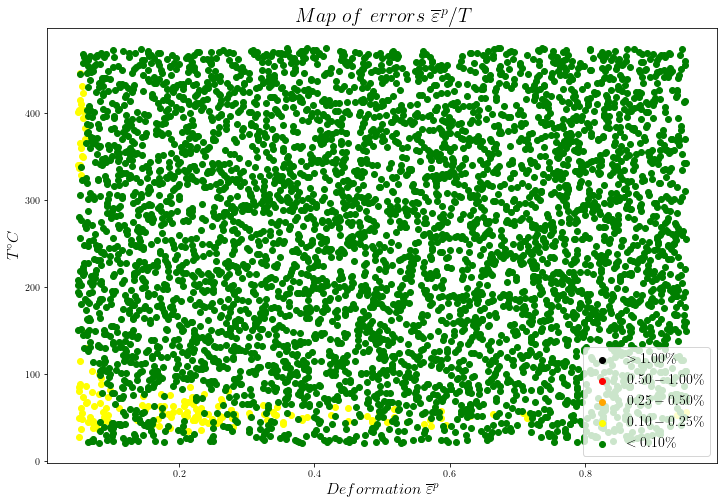

In [65]:
plt.figure(figsize = (12, 8))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], T_test[error >= levelsC[0]], color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
plt.ylabel(r'$T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \overline{\varepsilon}^{p} / T$', fontsize = 20)
plt.show()

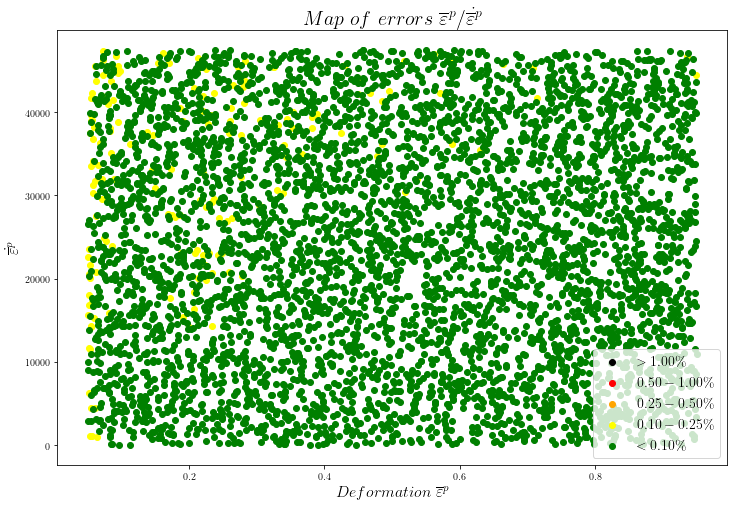

In [66]:
plt.figure(figsize = (12, 8))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
plt.ylabel(r'$\dot{\overline{\varepsilon}^{p}}$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \overline{\varepsilon}^{p} / \dot{\overline{\varepsilon}^{p}}$', fontsize = 20)
plt.show()

In [67]:
%matplotlib notebook

<IPython.core.display.Javascript object>


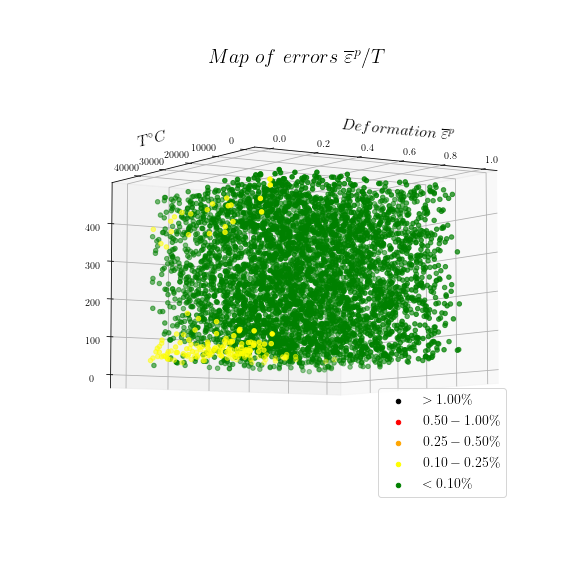

In [68]:
fig = plt.figure(figsize = (8, 8))
plt.rc('text', usetex = True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), T_test[error >= levelsC[0]], color='black', label=levelsT[0])
ax.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
ax.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
ax.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
ax.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
plt.ylabel(r'$T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \overline{\varepsilon}^{p} / T$', fontsize = 20)
plt.show()

In [69]:
loc = np.argmin(error)
loc = 200
dx = 1e-6
inp = np.array([testData[loc,0], testData[loc,1], testData[loc,2]])
sig = testData[loc,3]
sigEps = testData[loc,4]
sigEpsp = testData[loc,5]
sigT = testData[loc,6]

In [70]:
inp, loc

(array([7.54237492e-01, 4.71576189e+04, 2.46998038e+02]), 200)

In [71]:
inp0 = inp.copy()
inp = np.vstack([inp,inp0 + [[dx,0,0]]])
inp = np.vstack([inp,inp0 + [[0,dx,0]]])
inp = np.vstack([inp,inp0 + [[0,0,dx]]])
inp

array([[7.54237492e-01, 4.71576189e+04, 2.46998038e+02],
       [7.54238492e-01, 4.71576189e+04, 2.46998038e+02],
       [7.54237492e-01, 4.71576189e+04, 2.46998038e+02],
       [7.54237492e-01, 4.71576189e+04, 2.46998039e+02]])

In [72]:
for i in range(4): inp[i,1] = np.log(inp[i,1]/logBase)
inp

array([[  0.75423749,  10.76125086, 246.99803754],
       [  0.75423849,  10.76125086, 246.99803754],
       [  0.75423749,  10.76125086, 246.99803754],
       [  0.75423749,  10.76125086, 246.99803854]])

In [73]:
inp = (inp - minEntries[0:3]) / rangeEntries[0:3]
inp

array([[0.75423749, 0.9945907 , 0.47291258],
       [0.75423849, 0.9945907 , 0.47291258],
       [0.75423749, 0.9945907 , 0.47291258],
       [0.75423749, 0.9945907 , 0.47291258]])

In [74]:
if ('tanh' in ANN_name) : SigmaNN = tanh1Layer(inp.T)
elif ('sigmoid' in ANN_name) : SigmaNN = sigmoid1Layer(inp.T)
else : SigmaNN = 0
SigmaNN

array([[1337.12710182, 1337.12722744, 1337.12710182, 1337.1271009 ]])

In [75]:
SigmaNN[0][0], sig, abs((SigmaNN[0][0] - sig)/sig)

(1337.1271018195275, 1336.5738419673871, 0.0004139388597685121)

In [76]:
sigEpsN = (SigmaNN[0][1]-SigmaNN[0][0])/dx
sigEpsN, sigEps, abs((sigEpsN - sigEps)/sigEps)

(125.62062147480901, 125.27782530401564, 0.0027362876866796125)

In [77]:
sigEpspN = (SigmaNN[0][2]-SigmaNN[0][0])/dx
sigEpspN, sigEpsp, abs((sigEpspN - sigEpsp)/sigEpsp)

(0.00023010215954855084, 0.00023020229807541333, 0.0004350022901581865)

In [78]:
sigTN = (SigmaNN[0][3]-SigmaNN[0][0])/dx
sigTN, sigT, abs((sigTN- sigT)/sigT)

(-0.9165198662230978, -0.9124268148571577, 0.004485895525309442)

## Dérivation directe

In [79]:
x = inp[0].reshape(3,1)
x

array([[0.75423749],
       [0.9945907 ],
       [0.47291258]])

In [80]:
def tanhPrime1Layer(x):
    w2v = w2.reshape(w2.shape[1],1)
    s = (w1.T).dot(w2v - w2v*np.tanh(w1.dot(x) + b1)**2)
    return s

In [81]:
def sigmoidPrime1Layer(x):
    w2v = w2.reshape(w2.shape[1],1)
    y = w1.dot(x) + b1
    s = (w1.T).dot((w2v*np.exp(y))/(1+np.exp(y))**2)
    return s

In [82]:
if ('tanh' in ANN_name) : s = tanhPrime1Layer(x)
elif ('sigmoid' in ANN_name) : s = sigmoidPrime1Layer(x)
else : s = 0
s

array([[ 0.12850489],
       [ 0.11988316],
       [-0.4500304 ]])

In [83]:
scaleOut = np.array([[rangeEntries[3]/rangeEntries[0]],[rangeEntries[3]/rangeEntries[1]],[rangeEntries[3]/rangeEntries[2]]])
scaleOut

array([[977.55571504],
       [ 90.34895996],
       [  2.03657441]])

In [84]:
scaled = s*scaleOut
scaled

array([[125.62069292],
       [ 10.83131882],
       [ -0.91652039]])

In [85]:
sigEpsNN = scaled[0][0]
print(sigEpsNN)
print('Num : ',sigEpsN, abs((sigEpsNN-sigEpsN)/sigEpsN))
print('Ana : ',sigEps, abs((sigEpsNN-sigEps)/sigEps))

125.62069292488562
Num :  125.62062147480901 5.687766527888443e-07
Ana :  125.27782530401564 0.0027368580196689527


In [86]:
sigEpspNN = scaled[1][0]/testData[loc,1]
print(sigEpspNN)
print('Num : ',sigEpspN, abs((sigEpspNN-sigEpspN)/sigEpspN))
print('Ana : ',sigEpsp, abs((sigEpspNN-sigEpsp)/sigEpsp))

0.00022968332712750795
Num :  0.00023010215954855084 0.0018202020435819748
Ana :  0.00023020229807541333 0.0022544125416826526


In [87]:
sigTNN = scaled[2][0]
print(sigTNN)
print('Num : ',sigTN, abs((sigTNN-sigTN)/sigTN))
print('Ana : ',sigT, abs((sigTNN-sigT)/sigT))

-0.9165203929001476
Num :  -0.9165198662230978 5.74648809339731e-07
Ana :  -0.9124268148571577 0.004486472751933304


In [88]:
if ('tanh' in ANN_name) : sp = tanhPrime1Layer(inputTest.T)
elif ('sigmoid' in ANN_name) : sp = sigmoidPrime1Layer(inputTest.T)
else : sp = 0
sp

array([[ 0.41999231,  0.40824031,  0.23111185, ...,  0.46530007,
         0.50381488,  0.11593123],
       [ 0.11078154,  0.11466064,  0.11741513, ...,  0.10098607,
         0.10637503,  0.1110649 ],
       [-0.3981199 , -0.38442814, -0.41347923, ..., -0.41415326,
        -0.40176866, -0.46612139]])

In [89]:
ss = sp*scaleOut
error = np.abs((ss[0,:] - testData[:,4]) / testData[:,4])
"EPS", error.max(), error.min(), error.mean()

('EPS', 0.03897099368564366, 1.1822734981068821e-06, 0.0064732457892995995)

In [90]:
nnvals = ss[1]/testData[:,1]
error = np.abs((nnvals - testData[:,5]) / testData[:,5])
"EPSP", error.max(), error.min(), error.mean()

('EPSP', 0.0379836470597093, 1.0536953376838765e-06, 0.008713881187789634)

In [91]:
nnvals = ss[2]
error = np.abs((nnvals - testData[:,6]) / testData[:,6])
"T", error.max(), error.min(), error.mean()

('T', 0.35284355861812483, 4.525738421515412e-06, 0.012726374460444317)

In [92]:
levelsT = ['$> 5.00 \%$','$3.00 - 5.00 \%$','$1.00 - 3.00 \%$','$0.50 - 1.00 \%$','$< 0.50 \%$']
levelsC = [0.05, 0.03, 0.01, 0.005]

<IPython.core.display.Javascript object>


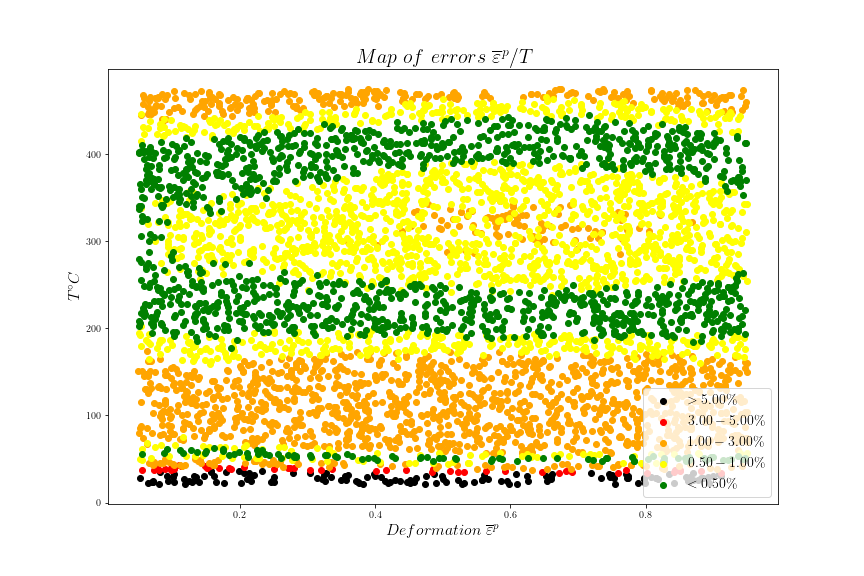

In [93]:
plt.figure(figsize = (12, 8))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], T_test[error >= levelsC[0]], color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
plt.ylabel(r'$T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \overline{\varepsilon}^{p} / T$', fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>


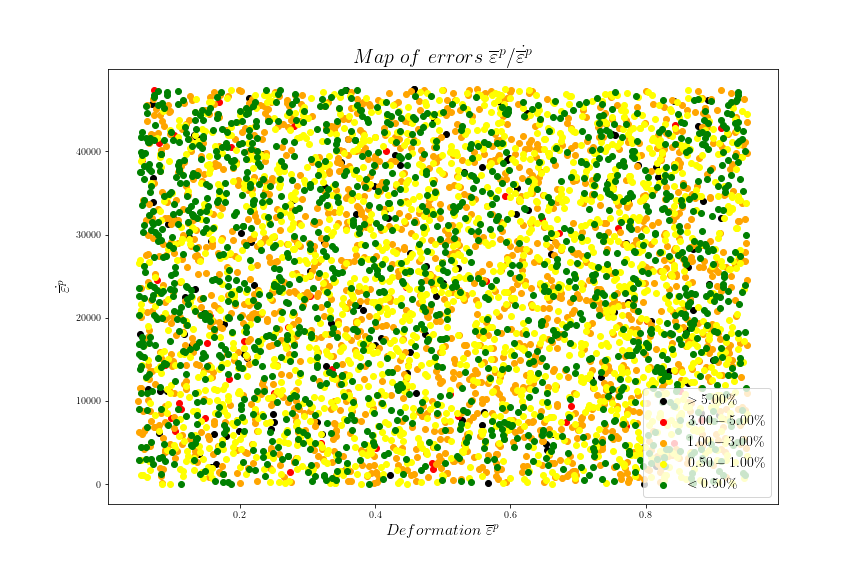

In [94]:
plt.figure(figsize = (12, 8))
plt.rc('text', usetex = True)
plt.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), color='black', label=levelsT[0])
plt.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), color='red', label=levelsT[1])
plt.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), color='orange', label=levelsT[2])
plt.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), color='yellow', label=levelsT[3])
plt.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
plt.ylabel(r'$\dot{\overline{\varepsilon}^{p}}$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \overline{\varepsilon}^{p} / \dot{\overline{\varepsilon}^{p}}$', fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>


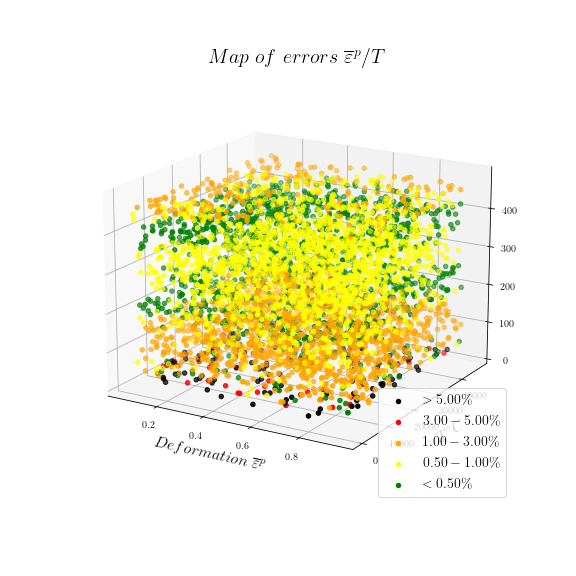

In [95]:
fig = plt.figure(figsize = (8, 8))
plt.rc('text', usetex = True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eps_test[error >= levelsC[0]], np.exp(epsp_test[error >= levelsC[0]]), T_test[error >= levelsC[0]], color='black', label=levelsT[0])
ax.scatter(eps_test[(error < levelsC[0]) & (error >= levelsC[1])], np.exp(epsp_test[(error < levelsC[0]) & (error >= levelsC[1])]), T_test[(error < levelsC[0]) & (error >= levelsC[1])], color='red', label=levelsT[1])
ax.scatter(eps_test[(error < levelsC[1]) & (error >= levelsC[2])], np.exp(epsp_test[(error < levelsC[1]) & (error >= levelsC[2])]), T_test[(error < levelsC[1]) & (error >= levelsC[2])], color='orange', label=levelsT[2])
ax.scatter(eps_test[(error < levelsC[2]) & (error >= levelsC[3])], np.exp(epsp_test[(error < levelsC[2]) & (error >= levelsC[3])]), T_test[(error < levelsC[2]) & (error >= levelsC[3])], color='yellow', label=levelsT[3])
ax.scatter(eps_test[error < levelsC[3]], np.exp(epsp_test[error < levelsC[3]]), T_test[error < levelsC[3]], color='green', label=levelsT[4])
plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
plt.ylabel(r'$T^{\circ}C$', fontsize = 16)
plt.title(r'$Map\ of\ errors\ \overline{\varepsilon}^{p} / T$', fontsize = 20)
plt.show()